# Arabic Handwritten Recognition

## Data Exploration


1. We need to mount to google drive to be able to use the uploaded dataset files.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


2. Import libraries necessary for this project.


In [2]:
# Import main libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Import libraries needed for reading image and processing it
import csv
from PIL import Image
from scipy.ndimage import rotate

# Pretty display for notebooks
%matplotlib inline

3. Load the dataset files into dataframes to be used later in the project

### Loading Arabic Digits Dataset

In [6]:
# Training digits images and labels files
digits_training_images_file_path = "drive/My Drive/Datasets/Arabic Handwritten Digits Dataset CSV/training images.zip"
digits_training_labels_file_path = "drive/My Drive/Datasets/Arabic Handwritten Digits Dataset CSV/training labels.zip"
# Testing digits images and labels files
digits_testing_images_file_path = "drive/My Drive/Datasets/Arabic Handwritten Digits Dataset CSV/testing images.zip"
digits_testing_labels_file_path = "drive/My Drive/Datasets/Arabic Handwritten Digits Dataset CSV/testing labels.zip"

# Loading dataset into dataframes
training_digits_images = pd.read_csv(digits_training_images_file_path, compression='zip', header=None)
training_digits_labels = pd.read_csv(digits_training_labels_file_path, compression='zip', header=None)
testing_digits_images = pd.read_csv(digits_testing_images_file_path, compression='zip', header=None)
testing_digits_labels = pd.read_csv(digits_testing_labels_file_path, compression='zip', header=None)

# print statistics about the dataset
print("There are %d training arabic digit images of 64x64 pixels." %training_digits_images.shape[0])
print("There are %d testing arabic digit images of 64x64 pixels." %testing_digits_images.shape[0])

There are 60000 training arabic digit images of 64x64 pixels.
There are 10000 testing arabic digit images of 64x64 pixels.


### Convert csv values to an image 
Writting a method to be used later if we want visualization of an image from its pixels values.

In [7]:
def convert_values_to_image(image_values, display=False):
  image_array = np.asarray(image_values)
  image_array = image_array.reshape(64, 64).astype('uint8')
  # The original dataset is reflected so we will flip it then rotate for a better view only.
  image_array = np.flip(image_array, 0)
  image_array = rotate(image_array, -90)
  new_image = Image.fromarray(image_array)
  if display == True:
    new_image.show()
  return new_image

### some examples

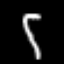

In [13]:
convert_values_to_image(training_digits_images.loc[2], True)

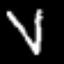

In [14]:
convert_values_to_image(training_digits_images.loc[7], True)

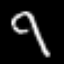

In [15]:
convert_values_to_image(training_digits_images.loc[9], True)

## Data Preprocessing

### Image Normalization
We rescale the images by dividing every pixel in the image by 255 to make them into range [0, 1]

In [16]:
training_digits_images_scaled = training_digits_images.values.astype('float32')/255
training_digits_labels = training_digits_labels.values.astype('int32')
testing_digits_images_scaled = testing_digits_images.values.astype('float32')/255
testing_digits_labels = testing_digits_labels.values.astype('int32')


In [17]:
print("Training images of digits after scaling")
print(training_digits_images_scaled.shape)
training_digits_images_scaled[0:5]

Training images of digits after scaling
(60000, 4096)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Encoding Categorical Labels

In [19]:
from keras.utils import to_categorical
number_of_classes = 10
training_digits_labels_encoded = to_categorical(training_digits_labels, num_classes=number_of_classes)
testing_digits_labels_encoded = to_categorical(testing_digits_labels, num_classes=number_of_classes)

Using TensorFlow backend.


In [20]:
print(training_digits_labels_encoded)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Reshaping Input Images to 64x64x1


In [21]:
# reshape input digit images to 64x64x1
training_digits_images_scaled = training_digits_images_scaled.reshape([-1, 64, 64, 1])
testing_digits_images_scaled = testing_digits_images_scaled.reshape([-1, 64, 64, 1])

print(training_digits_images_scaled.shape, training_digits_labels_encoded.shape, testing_digits_images_scaled.shape, testing_digits_labels_encoded.shape)

(60000, 64, 64, 1) (60000, 38) (10000, 64, 64, 1) (10000, 38)
(13440, 64, 64, 1) (13440, 38) (3360, 64, 64, 1) (3360, 38)


## Designing Model Architecture

In [24]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense

def create_model(optimizer='adam', kernel_initializer='he_normal', activation='relu'):
  # create model
  model = Sequential()
  model.add(Conv2D(filters=16, kernel_size=3, padding='same', input_shape=(64, 64, 1), kernel_initializer=kernel_initializer, activation=activation))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=32, kernel_size=3, padding='same', kernel_initializer=kernel_initializer, activation=activation))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer=kernel_initializer, activation=activation))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer=kernel_initializer, activation=activation))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(GlobalAveragePooling2D())
  
  #Fully connected final layer
  model.add(Dense(38, activation='softmax'))

  # Compile model
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
  return model

## Model Summary And Visualization

Let's see the model summary.

In [25]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)       

Keras support plotting the model in keras.utils.vis_utils module which provides utility functions to plot a Keras model using graphviz.

To be able to use that utility we should first install pydot and graphviz modules. This can be done by running the following code cell then restart the runtime environment.

In [26]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot

Now we can plot the model and save it to a file also.

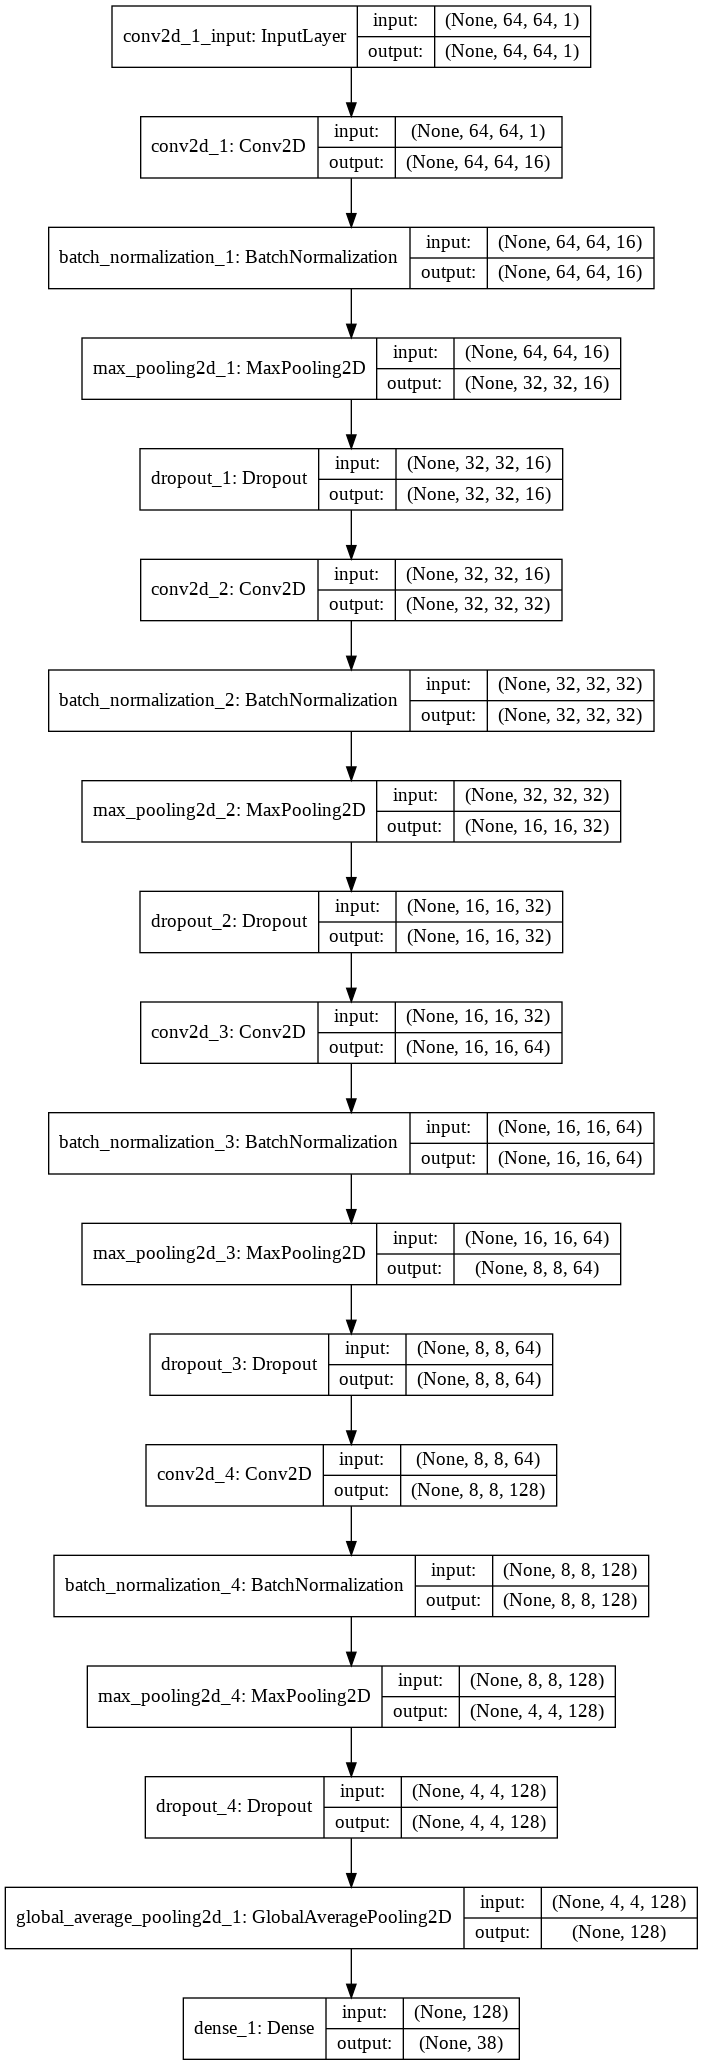

In [27]:
from keras.utils import plot_model

plot_model(model, to_file="model.png", show_shapes=True)
from IPython.display import Image as IPythonImage
display(IPythonImage('model.png'))

## Parameters Tuning

We will tune the parameters optimizer, kernel_initializer and activation.

In [ ]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# define the grid search parameters
optimizer = ['RMSprop', 'Adam', 'Adagrad', 'Nadam']
kernel_initializer = ['normal', 'uniform']
activation = ['relu', 'linear', 'tanh']

param_grid = dict(optimizer=optimizer, kernel_initializer=kernel_initializer, activation=activation)

# count number of different parameters values combinations
parameters_number = 1
for x in param_grid:
  parameters_number = parameters_number * len(param_grid[x]) 
print("Number of different parameter combinations = {}".format(parameters_number))

Number of different parameter combinations = 24


trying different models with different parameters to find the best parameter values.

In [ ]:
epochs = 5
batch_size = 20 # 20 divides the training data samples

#creating the models with different hyperparameters
for a,b,c in [(x,y,z) for x in optimizer for z in activation for y in kernel_initializer]:
    params = {'optimizer' : a , 'kernel_initializer' : b , 'activation' : c}
    print(params)
    curr_model = create_model(a, b, c)
    curr_model.fit(training_digit_images_scaled, training_digit_labels_encoded, 
                    validation_data=(testing_digit_images_scaled, testing_digits_labels_encoded),
                    epochs=epochs, batch_size=batch_size, verbose=1)
    print("=============================================================================")

{'optimizer': 'RMSprop', 'kernel_initializer': 'normal', 'activation': 'relu'}
Train on 73440 samples, validate on 13360 samples
Epoch 1/5
73440/73440 [==============================] - 84s 1ms/step - loss: 0.3349 - acc: 0.9089 - val_loss: 2.4386 - val_acc: 0.5037
Epoch 2/5
73440/73440 [==============================] - 82s 1ms/step - loss: 0.1106 - acc: 0.9670 - val_loss: 0.1605 - val_acc: 0.9507
Epoch 3/5
73440/73440 [==============================] - 81s 1ms/step - loss: 0.0865 - acc: 0.9738 - val_loss: 0.1138 - val_acc: 0.9665
Epoch 4/5
73440/73440 [==============================] - 81s 1ms/step - loss: 0.0788 - acc: 0.9772 - val_loss: 2.5557 - val_acc: 0.5233
Epoch 5/5
73440/73440 [==============================] - 81s 1ms/step - loss: 0.0710 - acc: 0.9788 - val_loss: 0.1519 - val_acc: 0.9559
{'optimizer': 'RMSprop', 'kernel_initializer': 'uniform', 'activation': 'relu'}
Train on 73440 samples, validate on 13360 samples
Epoch 1/5
73440/73440 [==============================] - 83s 

**From the above results we can see that best parameters are:**
* **Optimizer: Adam**
* **Kernel_initializer: uniform**
* **Activation: relu** 

Let's create the model with the best parameters obtained.

In [28]:
model = create_model(optimizer='Adam', kernel_initializer='uniform', activation='relu')

## Training the Model


### Fitting the Model

In [ ]:
from keras.callbacks import ModelCheckpoint  

# using checkpoints to save model weights to be used later instead of training again on the same epochs.
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)
history = model.fit(training_digit_images_scaled, training_digit_labels_encoded, 
                    validation_data=(testing_digit_images_scaled, testing_digit_labels_encoded),
                    epochs=10, batch_size=20, verbose=1, callbacks=[checkpointer])

Train on 73440 samples, validate on 13360 samples
Epoch 1/10
73440/73440 [==============================] - 94s 1ms/step - loss: 0.3189 - acc: 0.9153 - val_loss: 10.5339 - val_acc: 0.1437

Epoch 00001: val_loss improved from inf to 10.53390, saving model to weights.hdf5
Epoch 2/10
73440/73440 [==============================] - 89s 1ms/step - loss: 0.1049 - acc: 0.9681 - val_loss: 0.3283 - val_acc: 0.9012

Epoch 00002: val_loss improved from 10.53390 to 0.32826, saving model to weights.hdf5
Epoch 3/10
73440/73440 [==============================] - 90s 1ms/step - loss: 0.0797 - acc: 0.9757 - val_loss: 0.6523 - val_acc: 0.7985

Epoch 00003: val_loss did not improve from 0.32826
Epoch 4/10
73440/73440 [==============================] - 89s 1ms/step - loss: 0.0702 - acc: 0.9782 - val_loss: 0.2071 - val_acc: 0.9394

Epoch 00004: val_loss improved from 0.32826 to 0.20706, saving model to weights.hdf5
Epoch 5/10
73440/73440 [==============================] - 89s 1ms/step - loss: 0.0592 - acc: 

### Plotting Loss and Accuracy Curves with Epochs

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(history):
  # Loss Curves
  plt.figure(figsize=[8,6])
  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)

  # Accuracy Curves
  plt.figure(figsize=[8,6])
  plt.plot(history.history['acc'],'r',linewidth=3.0)
  plt.plot(history.history['val_acc'],'b',linewidth=3.0)
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16) 

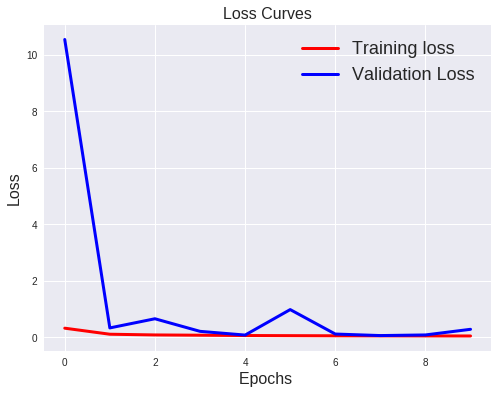

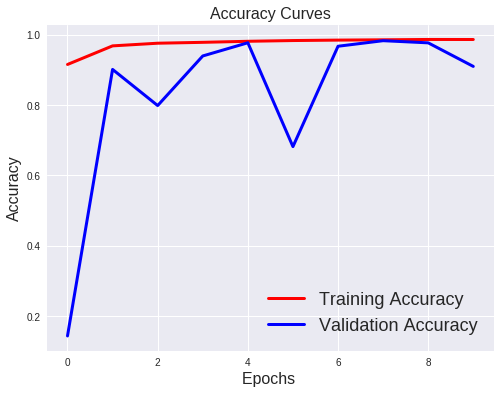

In [ ]:
plot_loss_accuracy(history)

### Load the Model with the Best Validation Loss


In [ ]:
model.load_weights('weights.hdf5')

## Test the Model


In [ ]:
# Final evaluation of the model
metrics = model.evaluate(testing_digit_images_scaled, testing_digit_labels_encoded, verbose=1)
print("Test Accuracy: {}".format(metrics[1]))
print("Test Loss: {}".format(metrics[0]))

13360/13360 [==============================] - 5s 343us/step
Test Accuracy: 0.9828592814371258
Test Loss: 0.05756271482567684


## Training More on the best model

Train on 73440 samples, validate on 13360 samples
Epoch 1/20
73440/73440 [==============================] - 89s 1ms/step - loss: 0.0447 - acc: 0.9859 - val_loss: 0.4244 - val_acc: 0.8557

Epoch 00001: val_loss improved from inf to 0.42443, saving model to weights.hdf5
Epoch 2/20
73440/73440 [==============================] - 89s 1ms/step - loss: 0.0414 - acc: 0.9863 - val_loss: 0.0576 - val_acc: 0.9830

Epoch 00002: val_loss improved from 0.42443 to 0.05760, saving model to weights.hdf5
Epoch 3/20
73440/73440 [==============================] - 89s 1ms/step - loss: 0.0396 - acc: 0.9872 - val_loss: 0.0546 - val_acc: 0.9844

Epoch 00003: val_loss improved from 0.05760 to 0.05457, saving model to weights.hdf5
Epoch 4/20
73440/73440 [==============================] - 89s 1ms/step - loss: 0.0400 - acc: 0.9875 - val_loss: 0.4204 - val_acc: 0.8711

Epoch 00004: val_loss did not improve from 0.05457
Epoch 5/20
73440/73440 [==============================] - 89s 1ms/step - loss: 0.0367 - acc: 0.9

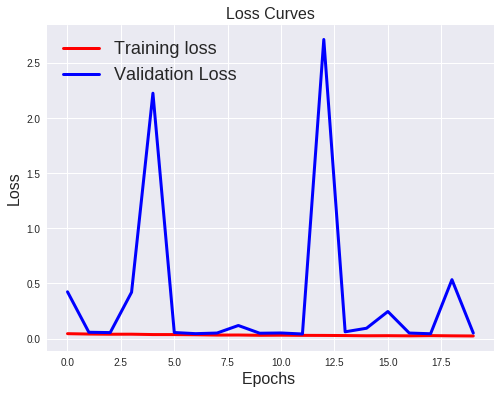

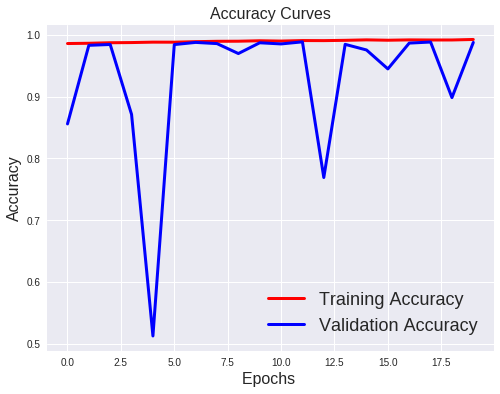

In [ ]:
epochs = 20
batch_size = 20

checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)

history = model.fit(training_digit_images_scaled, training_digit_labels_encoded, 
                    validation_data=(testing_digit_images_scaled, testing_digit_labels_encoded),
                    epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[checkpointer])
          
model.load_weights('weights.hdf5')
plot_loss_accuracy(history)

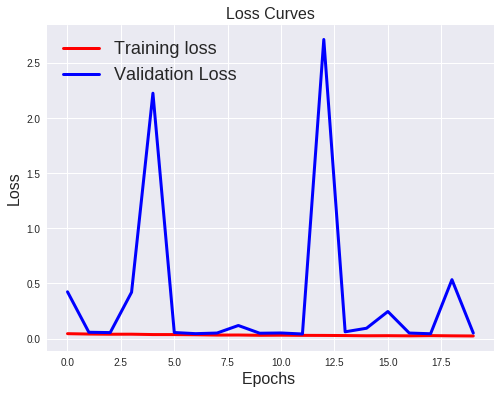

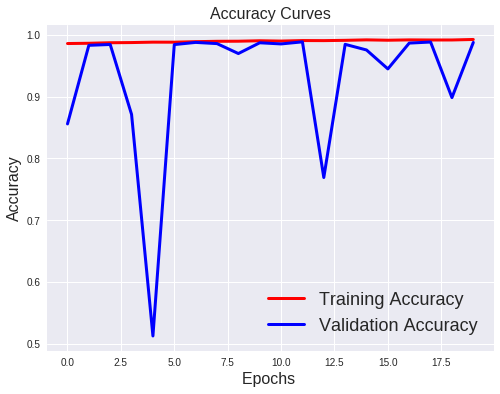

In [ ]:
plot_loss_accuracy(history)

## Testing the Model again

In [ ]:
# Final evaluation of the model
metrics = model.evaluate(testing_digit_images_scaled, testing_digit_labels_encoded, verbose=1)
print("Test Accuracy: {}".format(metrics[1]))
print("Test Loss: {}".format(metrics[0]))

13360/13360 [==============================] - 5s 346us/step
Test Accuracy: 0.988622754491018
Test Loss: 0.04191313635113142


## Saving the Final Model

In [23]:
from keras.models import model_from_yaml

In [29]:
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

Save the model weights to file.

In [ ]:
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


if we want to load the model with the last obtained weights at anytime, we will run the following code cell.

In [30]:
# load YAML and create model
yaml_file = open('model.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# compile the loaded model
loaded_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

Loaded model from disk


## Benchmark Model

In [ ]:
baseline_model = Sequential()
baseline_model.add(Conv2D(filters=16, kernel_size=3, padding='same', input_shape=(64, 64, 1), activation='relu')) # Input layer
baseline_model.add(GlobalAveragePooling2D())
baseline_model.add(Dense(38, activation = 'softmax')) # Output layer => output dimension = 38 as it is multi-class

# Compile the baseline model
baseline_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='Adam')

# Fit the baseline model with training dataset
epochs = 5
batch_size = 20

baseline_model.fit(training_digit_images_scaled, training_digit_labels_encoded, 
                  validation_data=(testing_digit_images_scaled, testing_digit_labels_encoded),
                  epochs=epochs, batch_size=batch_size, verbose=1)

# Test the baseline model
baseline_metrics = baseline_model.evaluate(testing_digit_images_scaled, testing_digit_labels_encoded, verbose=1)
print("Baseline Model Test Accuracy: {}".format(baseline_metrics[1]))
print("Baseline Model Test Loss: {}".format(baseline_metrics[0]))


Train on 73440 samples, validate on 13360 samples
Epoch 1/5
73440/73440 [==============================] - 45s 619us/step - loss: 2.7163 - acc: 0.1814 - val_loss: 2.7079 - val_acc: 0.2183
Epoch 2/5
73440/73440 [==============================] - 40s 550us/step - loss: 2.4709 - acc: 0.2514 - val_loss: 2.6120 - val_acc: 0.2372
Epoch 3/5
73440/73440 [==============================] - 40s 549us/step - loss: 2.3945 - acc: 0.2754 - val_loss: 2.5453 - val_acc: 0.2608
Epoch 4/5
73440/73440 [==============================] - 41s 552us/step - loss: 2.3237 - acc: 0.3069 - val_loss: 2.4661 - val_acc: 0.2959
Epoch 5/5
13360/13360 [==============================] - 2s 175us/step
Baseline Model Test Accuracy: 0.32372754491017963
Baseline Model Test Loss: 2.376121672327647


## Predict Image Classes

In [31]:
def get_predicted_classes(model, data, labels=None):
  image_predictions = model.predict(data)
  predicted_classes = np.argmax(image_predictions, axis=1)
  true_classes = np.argmax(labels, axis=1)
  return predicted_classes, true_classes

## Comparing Evaluation Metrics between Benchmark Model and Final Model

In [32]:
from sklearn.metrics import classification_report

def get_classification_report(y_true, y_pred):
  print(classification_report(y_true, y_pred))

### Evaluating Final Model using the specified metrics

In [ ]:
y_pred, y_true = get_predicted_classes(model, testing_digit_images_scaled, testing_digit_labels_encoded)
get_classification_report(y_true, y_pred)

### Evaluating Baseline (Benchmark) Model using the specified metrics

In [ ]:
y_pred, y_true = get_predicted_classes(baseline_model, testing_digit_images_scaled, testing_digit_labels_encoded)
get_classification_report(y_true, y_pred)

             precision    recall  f1-score   support

          0       0.95      0.84      0.89      1000
          1       0.25      0.90      0.39      1000
          2       0.29      0.23      0.26      1000
          3       0.24      0.28      0.25      1000
          4       0.31      0.29      0.30      1000
          5       0.52      0.73      0.61      1000
          6       0.18      0.37      0.24      1000
          7       0.28      0.64      0.39      1000
          8       0.00      0.00      0.00      1000
          9       0.16      0.03      0.04      1000
         10       0.00      0.00      0.00       120
         11       0.00      0.00      0.00       120
         12       0.00      0.00      0.00       120
         13       0.00      0.00      0.00       120
         14       0.00      0.00      0.00       120
         15       0.00      0.00      0.00       120
         16       0.00      0.00      0.00       120
         17       0.48      0.18      0.27   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [163]:
def get_non_zero_index_from_one_hot_encoding(one_hot_encoding):
  non_zero_index = np.where(one_hot_encoding == 1)[0]
  assert(len(non_zero_index) == 1)
  non_zero_index = non_zero_index[0]
  return non_zero_index

In [164]:
def convert_categorical_label_to_real_label(categorical_label):
  real_labels = []
  real_labels.extend([x for x in range(10)])
  real_labels.extend(['أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى'])
  return real_labels[categorical_label]

In [165]:
def show_example(sample_index):
  y_pred, y_true = get_predicted_classes(model, testing_digit_images_scaled[[sample_index]], testing_digit_labels_encoded[[sample_index]])
  non_zero_index = get_non_zero_index_from_one_hot_encoding(testing_digit_labels_encoded[sample_index])
  y_true = y_true[0]
  y_pred = y_pred[0]
  assert y_true == non_zero_index
  true_label = convert_categorical_label_to_real_label(y_true)
  predicted_label = convert_categorical_label_to_real_label(y_pred)
  print("The following image has the written character '{}' but the model predicted it as '{}'".format(true_label, predicted_label))
  return true_label == predicted_label

The following image has the written character '5' but the model predicted it as '5'


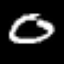

In [166]:
sample_index = 5
show_example(sample_index)
convert_values_to_image(testing_digits_images_scaled.loc[sample_index], True)

## Conclusion

**built a CNN model which can classify the arabic handwritten images into digits. I tested the model and got very high accuracy of 98.86%.**